# TNT Cates (Living Polymers): Flow Curve

## Objectives
- Fit TNTCates model to steady shear flow curve data
- Extract reptation time (tau_rep) and breaking time (tau_break) for wormlike micelles
- Analyze effective relaxation time tau_d = sqrt(tau_rep * tau_break)
- Check for fast-breaking limit and non-monotonic flow curve
- Perform Bayesian inference with NUTS

**Note:** Carbopol is not a wormlike micellar system. We use this data to demonstrate the Cates model workflow.

## Setup

In [1]:
import os
import sys
import time

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax

import numpy as np
import matplotlib.pyplot as plt
import arviz as az

from rheojax.core.jax_config import safe_import_jax
jax, jnp = safe_import_jax()
from rheojax.core.jax_config import verify_float64
verify_float64()

from rheojax.models.tnt import TNTCates

sys.path.insert(0, os.path.join("..", "utils"))
from tnt_tutorial_utils import (
    load_ml_ikh_flow_curve,
    compute_fit_quality,
    print_convergence_summary,
    print_parameter_comparison,
    save_tnt_results,
    get_tnt_cates_param_names,
    compute_cates_tau_d,
)

param_names = get_tnt_cates_param_names()
print(f"TNTCates parameters: {param_names}")

TNTCates parameters: ['G_0', 'tau_rep', 'tau_break', 'eta_s']


## Theory: Cates Model for Wormlike Micelles

The Cates model describes living polymers (wormlike micelles) undergoing reversible scission and recombination:

**Key time scales:**
- $\tau_{\text{rep}}$: Reptation time (chain diffusion)
- $\tau_{\text{break}}$: Breaking time (scission rate)
- $\tau_d = \sqrt{\tau_{\text{rep}} \cdot \tau_{\text{break}}}$: Effective relaxation time

**Flow curve (steady shear):**
$$\sigma(\dot{\gamma}) = \frac{G_0 \tau_d \dot{\gamma}}{1 + (\tau_d \dot{\gamma})^2} + \eta_s \dot{\gamma}$$

**Fast-breaking limit:** When $\zeta = \tau_{\text{break}}/\tau_{\text{rep}} \ll 1$, the model reduces to single-mode Maxwell with $\tau = \tau_d$.

**Non-monotonic flow curve:** If $\partial\sigma/\partial\dot{\gamma} < 0$, shear banding may occur.

## Load Flow Curve Data

Data points: 21
Shear rate range: 1.00e-02 to 1.00e+02 s^-1
Stress range: 0.75 to 51.46 Pa


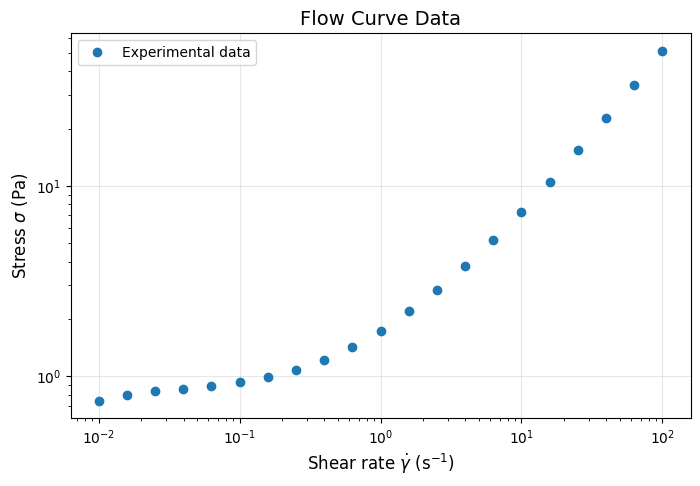

In [2]:
gamma_dot, stress = load_ml_ikh_flow_curve("ARES_up")

print(f"Data points: {len(gamma_dot)}")
print(f"Shear rate range: {gamma_dot.min():.2e} to {gamma_dot.max():.2e} s^-1")
print(f"Stress range: {stress.min():.2f} to {stress.max():.2f} Pa")

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(gamma_dot, stress, 'o', label='Experimental data', markersize=6)
ax.set_xlabel(r'Shear rate $\dot{\gamma}$ (s$^{-1}$)', fontsize=12)
ax.set_ylabel(r'Stress $\sigma$ (Pa)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_title('Flow Curve Data', fontsize=14)
plt.show()
plt.close('all')

## NLSQ Fitting

In [3]:
model = TNTCates()

start_time = time.time()
model.fit(gamma_dot, stress, test_mode='flow_curve', method='scipy')
fit_time = time.time() - start_time

print(f"\nNLSQ Optimization completed in {fit_time:.2f} seconds")

# Extract fitted parameters
nlsq_params = {name: model.parameters.get_value(name) for name in param_names}
print("\nNLSQ Parameters:")
for name, value in nlsq_params.items():
    print(f"  {name}: {value:.4e}")

# Compute fit quality
stress_pred_fit = model.predict(gamma_dot, test_mode='flow_curve')
quality = compute_fit_quality(stress, stress_pred_fit)
print(f"\nFit Quality: R² = {quality['R2']:.6f}, RMSE = {quality['RMSE']:.4e}")


NLSQ Optimization completed in 0.41 seconds

NLSQ Parameters:
  G_0: 2.7595e+01
  tau_rep: 2.6632e-01
  tau_break: 2.6632e-03
  eta_s: 2.6622e-12

Fit Quality: R² = 0.796552, RMSE = 5.7898e+00


## Visualize NLSQ Fit

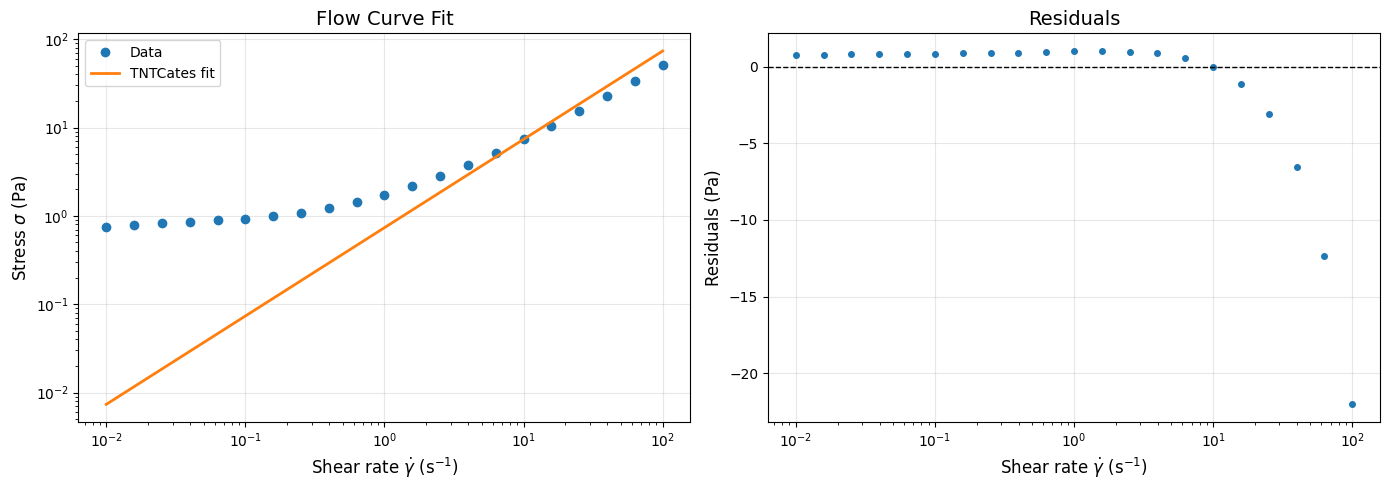

In [4]:
gamma_dot_pred = jnp.logspace(jnp.log10(gamma_dot.min()), jnp.log10(gamma_dot.max()), 200)
stress_pred = model.predict(gamma_dot_pred, test_mode='flow_curve')

# Compute residuals
residuals = stress - model.predict(gamma_dot, test_mode='flow_curve')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.loglog(gamma_dot, stress, 'o', label='Data', markersize=6)
ax1.loglog(gamma_dot_pred, stress_pred, '-', linewidth=2, label='TNTCates fit')
ax1.set_xlabel(r'Shear rate $\dot{\gamma}$ (s$^{-1}$)', fontsize=12)
ax1.set_ylabel(r'Stress $\sigma$ (Pa)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_title('Flow Curve Fit', fontsize=14)

ax2.semilogx(gamma_dot, residuals, 'o', markersize=4)
ax2.axhline(0, color='k', linestyle='--', linewidth=1)
ax2.set_xlabel(r'Shear rate $\dot{\gamma}$ (s$^{-1}$)', fontsize=12)
ax2.set_ylabel('Residuals (Pa)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_title('Residuals', fontsize=14)

plt.tight_layout()
plt.show()
plt.close('all')

## Physical Analysis

In [5]:
tau_d = compute_cates_tau_d(nlsq_params['tau_rep'], nlsq_params['tau_break'])
zeta = nlsq_params['tau_break'] / nlsq_params['tau_rep']

print(f"\nPhysical Analysis:")
print(f"  Reptation time (tau_rep): {nlsq_params['tau_rep']:.4e} s")
print(f"  Breaking time (tau_break): {nlsq_params['tau_break']:.4e} s")
print(f"  Effective relaxation time (tau_d): {tau_d:.4e} s")
print(f"  Fast-breaking parameter (zeta): {zeta:.4f}")

if zeta < 0.1:
    print(f"  → Fast-breaking limit (zeta < 0.1): Model approximates single-mode Maxwell")
else:
    print(f"  → Not in fast-breaking limit: Full Cates dynamics active")

d_stress = jnp.gradient(stress_pred, gamma_dot_pred)
if jnp.any(d_stress < 0):
    print(f"  ⚠ Non-monotonic flow curve detected: Potential shear banding")
else:
    print(f"  ✓ Monotonic flow curve: No shear banding predicted")


Physical Analysis:
  Reptation time (tau_rep): 2.6632e-01 s
  Breaking time (tau_break): 2.6632e-03 s
  Effective relaxation time (tau_d): 2.6632e-02 s
  Fast-breaking parameter (zeta): 0.0100
  → Fast-breaking limit (zeta < 0.1): Model approximates single-mode Maxwell
  ✓ Monotonic flow curve: No shear banding predicted


## Bayesian Inference with NUTS

In [6]:
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

print(f"Starting Bayesian inference with NUTS...")
print(f"Warmup: {NUM_WARMUP}, Samples: {NUM_SAMPLES}, Chains: {NUM_CHAINS}")

start_time = time.time()
bayesian_result = model.fit_bayesian(
    gamma_dot, stress,
    test_mode='flow_curve',
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    seed=42
)
bayes_time = time.time() - start_time

print(f"\nBayesian inference completed in {bayes_time:.2f} seconds")
print(f"Time per sample: {bayes_time/(NUM_WARMUP + NUM_SAMPLES):.3f} seconds")

Starting Bayesian inference with NUTS...
Warmup: 200, Samples: 500, Chains: 1


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<08:26,  1.38it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   3%|▎         | 24/700 [00:00<00:17, 38.95it/s, 831 steps of size 3.45e-03. acc. prob=0.87]

warmup:   9%|▉         | 63/700 [00:00<00:06, 105.11it/s, 1023 steps of size 1.82e-02. acc. prob=0.94]

warmup:  14%|█▍        | 97/700 [00:01<00:03, 154.98it/s, 319 steps of size 1.59e-02. acc. prob=0.95] 

warmup:  18%|█▊        | 126/700 [00:01<00:03, 165.31it/s, 511 steps of size 4.09e-03. acc. prob=0.95]

warmup:  22%|██▏       | 151/700 [00:01<00:03, 165.89it/s, 1023 steps of size 4.08e-02. acc. prob=0.96]

warmup:  25%|██▍       | 174/700 [00:01<00:03, 171.94it/s, 1023 steps of size 3.42e-03. acc. prob=0.96]

sample:  29%|██▉       | 202/700 [00:01<00:02, 196.17it/s, 1023 steps of size 3.36e-03. acc. prob=0.96]

sample:  33%|███▎      | 229/700 [00:01<00:02, 214.55it/s, 1023 steps of size 3.36e-03. acc. prob=0.99]

sample:  36%|███▋      | 254/700 [00:01<00:02, 192.47it/s, 1023 steps of size 3.36e-03. acc. prob=0.99]

sample:  39%|███▉      | 276/700 [00:01<00:02, 181.65it/s, 511 steps of size 3.36e-03. acc. prob=0.99] 

sample:  42%|████▏     | 297/700 [00:02<00:02, 187.71it/s, 1023 steps of size 3.36e-03. acc. prob=0.99]

sample:  46%|████▋     | 324/700 [00:02<00:01, 206.09it/s, 1023 steps of size 3.36e-03. acc. prob=0.99]

sample:  49%|████▉     | 346/700 [00:02<00:01, 205.36it/s, 23 steps of size 3.36e-03. acc. prob=0.99]  

sample:  53%|█████▎    | 368/700 [00:02<00:01, 184.18it/s, 1023 steps of size 3.36e-03. acc. prob=0.99]

sample:  55%|█████▌    | 388/700 [00:02<00:01, 176.80it/s, 1023 steps of size 3.36e-03. acc. prob=0.99]

sample:  59%|█████▊    | 411/700 [00:02<00:01, 189.73it/s, 447 steps of size 3.36e-03. acc. prob=0.99] 

sample:  62%|██████▏   | 431/700 [00:02<00:01, 186.65it/s, 1023 steps of size 3.36e-03. acc. prob=0.99]

sample:  64%|██████▍   | 451/700 [00:02<00:01, 175.65it/s, 1023 steps of size 3.36e-03. acc. prob=0.99]

sample:  68%|██████▊   | 476/700 [00:02<00:01, 194.07it/s, 511 steps of size 3.36e-03. acc. prob=0.99] 

sample:  71%|███████▏  | 499/700 [00:03<00:00, 203.77it/s, 1023 steps of size 3.36e-03. acc. prob=0.99]

sample:  75%|███████▍  | 522/700 [00:03<00:00, 209.79it/s, 1023 steps of size 3.36e-03. acc. prob=0.99]

sample:  78%|███████▊  | 544/700 [00:03<00:00, 205.22it/s, 1023 steps of size 3.36e-03. acc. prob=0.99]

sample:  81%|████████  | 568/700 [00:03<00:00, 213.23it/s, 1023 steps of size 3.36e-03. acc. prob=0.99]

sample:  85%|████████▍ | 592/700 [00:03<00:00, 218.03it/s, 1023 steps of size 3.36e-03. acc. prob=0.99]

sample:  88%|████████▊ | 614/700 [00:03<00:00, 194.46it/s, 1023 steps of size 3.36e-03. acc. prob=0.99]

sample:  91%|█████████ | 634/700 [00:03<00:00, 172.93it/s, 1023 steps of size 3.36e-03. acc. prob=0.99]

sample:  93%|█████████▎| 652/700 [00:03<00:00, 169.49it/s, 1023 steps of size 3.36e-03. acc. prob=0.99]

sample:  96%|█████████▌| 672/700 [00:04<00:00, 175.95it/s, 1023 steps of size 3.36e-03. acc. prob=0.99]

sample:  99%|█████████▊| 691/700 [00:04<00:00, 170.18it/s, 1023 steps of size 3.36e-03. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:04<00:00, 167.54it/s, 1023 steps of size 3.36e-03. acc. prob=0.99]


Bayesian inference completed in 6.86 seconds
Time per sample: 0.010 seconds


## Convergence Diagnostics

In [7]:
posterior = bayesian_result.posterior_samples

bayesian_params = {name: float(jnp.mean(posterior[name])) for name in param_names}
param_std = {name: float(jnp.std(posterior[name])) for name in param_names}

print("\nPosterior Statistics:")
for name in param_names:
    print(f"  {name}: {bayesian_params[name]:.4e} ± {param_std[name]:.4e}")

# Compare NLSQ vs Bayesian using the utility function
print_parameter_comparison(model, posterior, param_names)


Posterior Statistics:
  G_0: 1.8622e+01 ± 1.7026e+02
  tau_rep: 2.2768e+03 ± 1.3107e+04
  tau_break: 4.2370e+01 ± 2.0322e+02
  eta_s: 1.7086e-01 ± 1.2142e-01

Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
            G_0          27.6         2.043  [1.015, 34.33]
        tau_rep        0.2663        0.1879  [0.0001417, 1.761e+04]
      tau_break      0.002663       0.05338  [1.665e-06, 498]
          eta_s     2.662e-12        0.1526  [0.004845, 0.4209]


## ArviZ Trace Plot

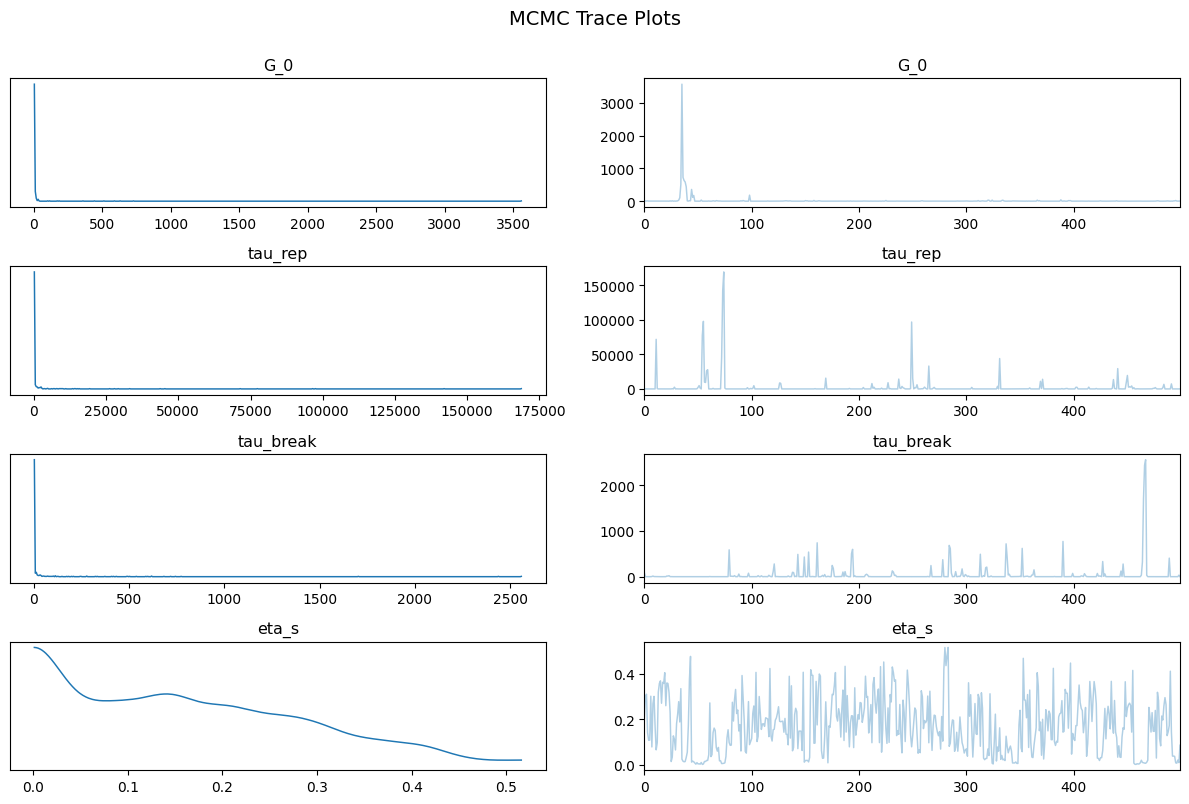

In [8]:
idata = az.from_dict(posterior={k: v.reshape(NUM_CHAINS, NUM_SAMPLES) for k, v in posterior.items()})

axes = az.plot_trace(idata, var_names=param_names, compact=False, figsize=(12, 8))
plt.suptitle('MCMC Trace Plots', fontsize=14, y=1.0)
plt.tight_layout()
plt.show()
plt.close('all')

## ArviZ Pair Plot

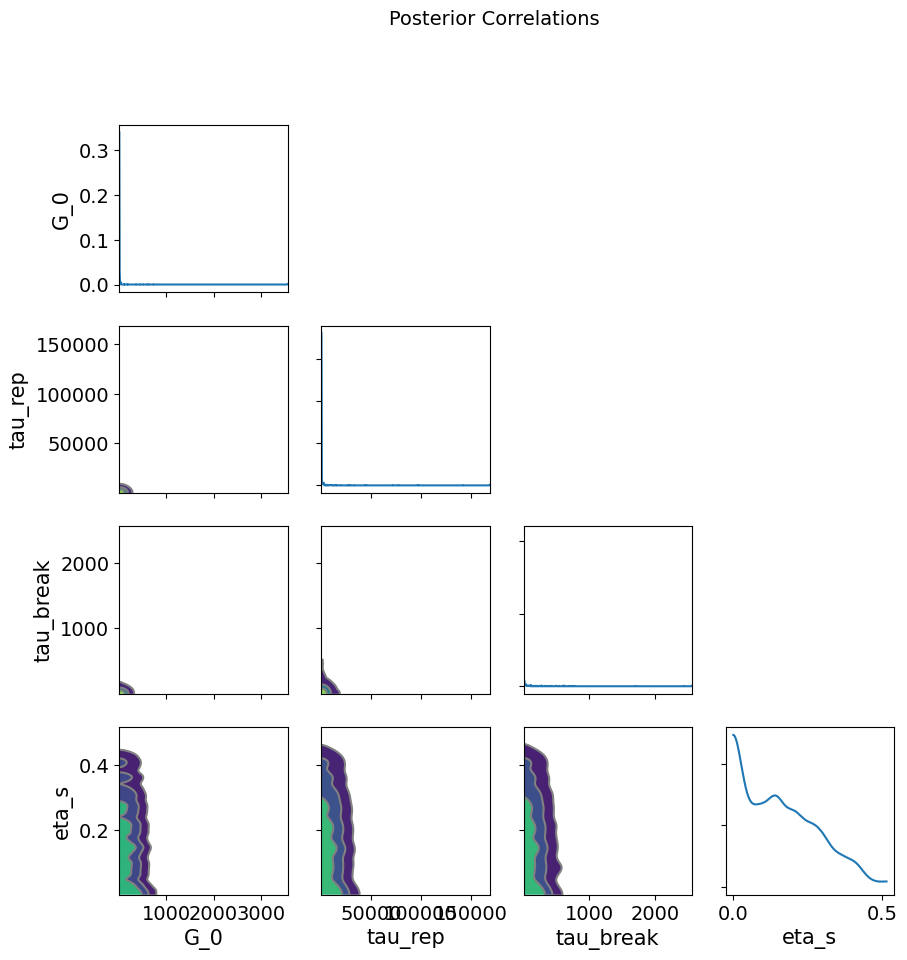

In [9]:
axes = az.plot_pair(
    idata,
    var_names=param_names,
    kind='kde',
    marginals=True,
    figsize=(10, 10)
)
plt.suptitle('Posterior Correlations', fontsize=14, y=0.995)
plt.show()
plt.close('all')

## ArviZ Forest Plot

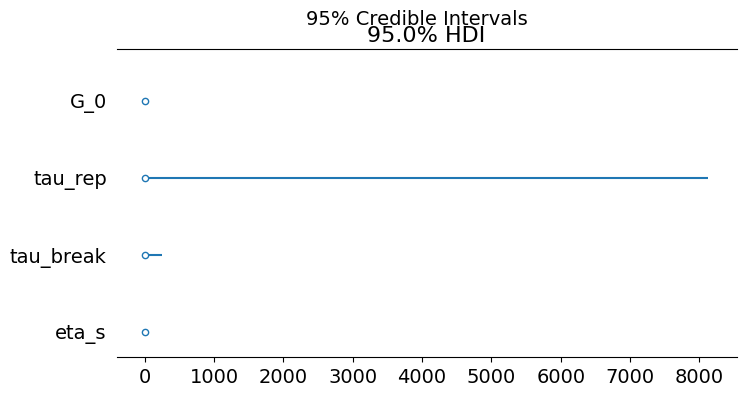

In [10]:
axes = az.plot_forest(
    idata,
    var_names=param_names,
    combined=True,
    hdi_prob=0.95,
    figsize=(8, 4)
)
plt.suptitle('95% Credible Intervals', fontsize=14)
plt.show()
plt.close('all')

## Posterior Predictive Distribution

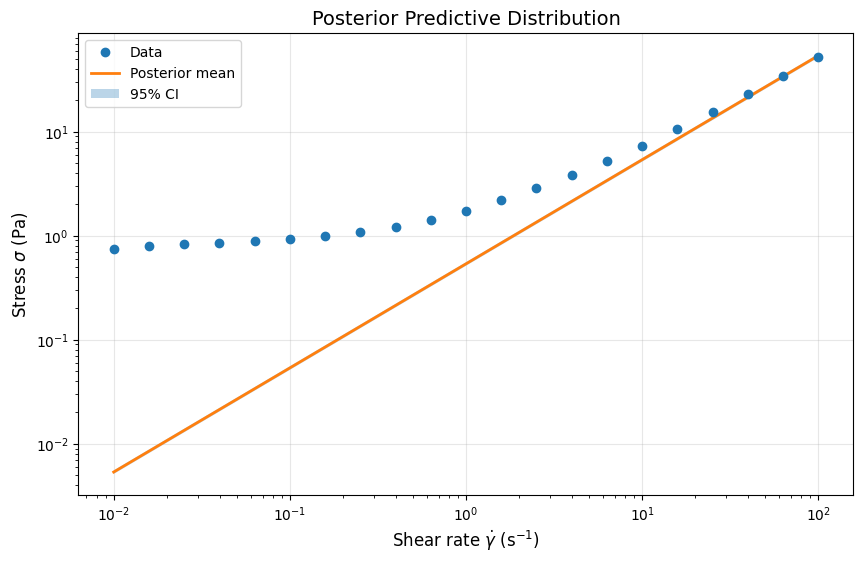

In [11]:
n_posterior_samples = 200
sample_indices = np.random.choice(NUM_SAMPLES * NUM_CHAINS, n_posterior_samples, replace=False)

predictions = []
for idx in sample_indices:
    # Set model parameters from posterior sample
    for j, name in enumerate(param_names):
        model.parameters.set_value(name, float(posterior[name].flatten()[idx]))
    # Predict with updated parameters
    pred_i = model.predict(gamma_dot_pred, test_mode='flow_curve')
    predictions.append(np.array(pred_i))

predictions = np.array(predictions)
pred_mean = np.mean(predictions, axis=0)
pred_lower = np.percentile(predictions, 2.5, axis=0)
pred_upper = np.percentile(predictions, 97.5, axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(gamma_dot, stress, 'o', label='Data', markersize=6, zorder=3)
ax.loglog(gamma_dot_pred, pred_mean, '-', linewidth=2, label='Posterior mean', zorder=2)
ax.fill_between(gamma_dot_pred, pred_lower, pred_upper, alpha=0.3, label='95% CI', zorder=1)
ax.set_xlabel(r'Shear rate $\dot{\gamma}$ (s$^{-1}$)', fontsize=12)
ax.set_ylabel(r'Stress $\sigma$ (Pa)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_title('Posterior Predictive Distribution', fontsize=14)
plt.show()
plt.close('all')

## Physical Interpretation from Posterior


Physical quantities from posterior:
  tau_d: 1.8057e-01 ± 1.3082e-01 s
  zeta (tau_break/tau_rep): 261258.3174 ± 1701565.8855


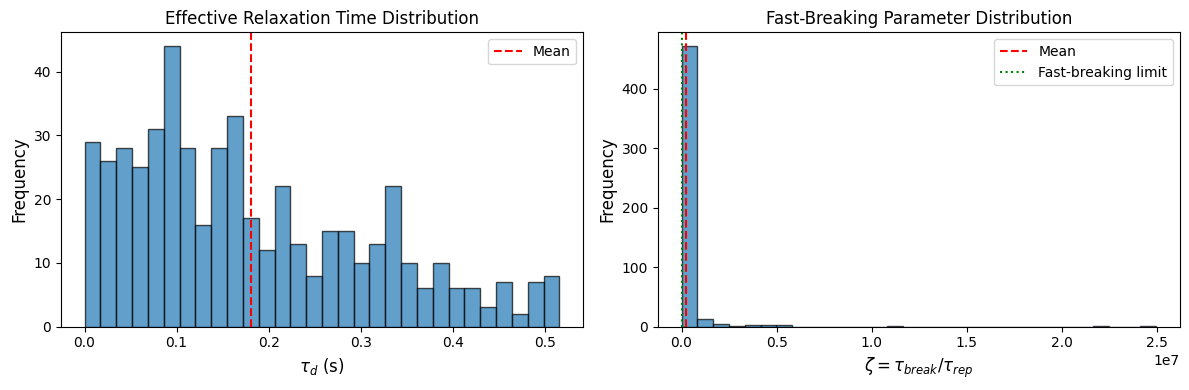

In [12]:
tau_d_posterior = np.sqrt(posterior['tau_rep'] * posterior['tau_break'])
zeta_posterior = posterior['tau_break'] / posterior['tau_rep']

print(f"\nPhysical quantities from posterior:")
print(f"  tau_d: {np.mean(tau_d_posterior):.4e} ± {np.std(tau_d_posterior):.4e} s")
print(f"  zeta (tau_break/tau_rep): {np.mean(zeta_posterior):.4f} ± {np.std(zeta_posterior):.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(tau_d_posterior, bins=30, alpha=0.7, edgecolor='black')
ax1.axvline(np.mean(tau_d_posterior), color='r', linestyle='--', label='Mean')
ax1.set_xlabel(r'$\tau_d$ (s)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.legend()
ax1.set_title('Effective Relaxation Time Distribution', fontsize=12)

ax2.hist(zeta_posterior, bins=30, alpha=0.7, edgecolor='black')
ax2.axvline(np.mean(zeta_posterior), color='r', linestyle='--', label='Mean')
ax2.axvline(0.1, color='g', linestyle=':', label='Fast-breaking limit')
ax2.set_xlabel(r'$\zeta = \tau_{break}/\tau_{rep}$', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.legend()
ax2.set_title('Fast-Breaking Parameter Distribution', fontsize=12)

plt.tight_layout()
plt.show()
plt.close('all')

## Save Results

In [13]:
save_tnt_results(model, bayesian_result, "cates", "flow_curve", param_names)

Results saved to /Users/b80985/Projects/rheojax/examples/tnt/../utils/../outputs/tnt/cates/flow_curve/
  nlsq_params_flow_curve.json: 4 parameters
  posterior_flow_curve.json: 500 draws


## Key Takeaways

1. **TNTCates captures living polymer dynamics** through reptation and scission times
2. **Effective relaxation time** $\tau_d = \sqrt{\tau_{\text{rep}} \cdot \tau_{\text{break}}}$ governs flow curve shape
3. **Fast-breaking limit** ($\zeta \ll 1$) reduces to single-mode Maxwell behavior
4. **Non-monotonic flow curves** indicate potential shear banding in wormlike micelles
5. **Bayesian inference** quantifies uncertainty in time scales and plateau modulus

**Next steps:** Explore other protocols (startup, SAOS, LAOS) to validate extracted parameters across different deformation modes.